In [1]:
#!/usr/bin/env python
# coding: utf-8

import os, sys
import numpy as np
import h5netcdf

import xarray as xr
import xarray.ufuncs as xu
import xrft
import pandas as pd
from wrf import smooth2d

from matplotlib import pyplot as plt

import cartopy.crs as ccrs
import cartopy

plt.rc("figure", figsize=(8,7))
plt.rc("font", size=14)

###


from dask.distributed import Client, LocalCluster
from dask.diagnostics import ProgressBar
#
# Initialisation d'un cluster de 32 coeurs
cluster = LocalCluster(processes=False, n_workers=1, threads_per_worker=4, protocol = 'tcp')
client = Client(cluster)
client

/home/durandy/miniconda3/envs/towel/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39003 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:39003/status,
Dashboard: http://127.0.0.1:39003/status,Workers: 1
Total threads: 4,Total memory: 78.61 GiB
Status: running,Using processes: False
Comm: tcp://127.0.0.1:44973,Workers: 1
Dashboard: http://127.0.0.1:39003/status,Total threads: 4
Started: Just now,Total memory: 78.61 GiB
Comm: tcp://127.0.0.1:34697,Total threads: 4
Dashboard: http://127.0.0.1:36611/status,Memory: 78.61 GiB
Nanny: None,


In [2]:
path = "/home/durand/Documents/OLR/"
# path = ""

indir_data = path + 'Anomaly/'
indir_data = '/cnrm/tropics/commun/DATACOMMUN/WAVE/SCRIPTS/'
outdir_TF = path + 'TF2D/'
"""
indir_data = '/cnrm/tropics/commun/DATACOMMUN/WAVE/NO_SAVE/DATA/RAW_ANOMALY/OLR/'
outdir_TF = '/cnrm/tropics/commun/DATACOMMUN/WAVE/NO_SAVE/DATA/TF2D/OLR/'
"""
var = 'OLR'
prefix = 'TF2D'

addDay = 180

In [3]:
def convolvePosNeg(arr, k, dim, boundary_index):
    """Apply convolution of (arr, k) excluding data at boundary_index in dimension dim.
    
    arr: numpy ndarray of data
    k: numpy ndarray, same dimension as arr, this should be the kernel
    dim: integer indicating the axis of arr to split
    boundary_index: integer indicating the position to split dim
    
    Split array along dim at boundary_index;
    perform convolution on each sub-array;
    reconstruct output array from the two subarrays;
    the values of output at boundary_index of dim will be same as input.
    
    `convolve2d` is `scipy.signal.convolve2d()`
    """
    # arr: numpy ndarray
    oarr = arr.copy()  # maybe not good to make a fresh copy every time?
    # first pass is [0 : boundary_index)
    slc1 = [slice(None)] * arr.ndim
    slc1[dim] = slice(None, boundary_index)
    arr1 = arr[tuple(slc1)]
    ans1 = convolve2d(arr1, k, boundary='symm', mode='same')
    # second pass is [boundary_index+1, end]
    slc2 = [slice(None)] * arr.ndim
    slc2[dim] = slice(boundary_index+1,None)
    arr2 = arr[tuple(slc2)]
    ans2 = convolve2d(arr2, k, boundary='symm', mode='same')
    # fill in the output array
    oarr[tuple(slc1)] = ans1
    oarr[tuple(slc2)] = ans2
    return oarr

def simple_smooth_kernel():
    """Provide a very simple smoothing kernel."""
    kern = np.array([[0, 1, 0],[1, 2, 1],[0, 1, 0]])
    return kern / kern.sum()

def smooth_wavefreq(data, kern=None, nsmooth=None, freq_ax=None, freq_name=None):
    """Apply a convolution of (data,kern) nsmooth times.
       The convolution is applied separately to the positive and negative frequencies.
       Either the name (freq_name: str) or axis index (freq_ax: int) of frequency is required, with the name preferred.
    """
    assert isinstance(data, xr.DataArray)
    if kern is None:
        kern = simple_smooth_kernel()
    if nsmooth is None:
        nsmooth = 20
    if freq_name is not None:
        axnum = list(data.dims).index(freq_name)
        nzero =  data.sizes[freq_name] // 2 # <-- THIS IS SUPPOSED TO BE THE INDEX AT FREQ==0.0
    elif freq_ax is not None:
        axnum = freq_ax
        nzero = data.shape[freq_ax] // 2
    else:
        raise ValueError("smooth_wavefreq needs to know how to find frequency dimension.")
    smth1pass = convolvePosNeg(data, kern, axnum, nzero) # this is a custom function to skip 0-frequency (mean)
    # note: the convolution is strictly 2D and the boundary condition is symmetric --> if kernel is normalized, preserves the sum.
    smth1pass = xr.DataArray(smth1pass, dims=data.dims, coords=data.coords) # ~copy_metadata
    # repeat smoothing many times:
    smthNpass = smth1pass.values.copy()
    for i in range(nsmooth):
        smthNpass = convolvePosNeg(smthNpass, kern, axnum, nzero)
    return xr.DataArray(smthNpass, dims=data.dims, coords=data.coords)



In [4]:
def  decompose2SymAsym(arr):
    """Mimic NCL function to decompose into symmetric and asymmetric parts.
    
    arr: xarra DataArray
    return: DataArray with symmetric in SH, asymmetric in NH
    Note:
        This function produces indistinguishable results from NCL version.
    """
#     lat_dim = arr.dims.index('lat')
#     print(lat_dim)
    # flag to follow NCL convention and put symmetric component in SH 
    # & asymmetric in NH
    # method: use flip to reverse latitude, put in DataArray for coords, use loc/isel
    # to assign to negative/positive latitudes (exact equator is left alone)
    _arr = arr.reindex(lat=arr.lat[::-1])
    _arr['lat'] = arr.lat
    data_sym = 0.5*(arr + _arr)
    data_asy = 0.5*(arr - _arr)
    data_sym = xr.DataArray(data_sym, dims=arr.dims, coords=arr.coords)
    data_asy = xr.DataArray(data_asy, dims=arr.dims, coords=arr.coords)
    out = arr.copy()  # might not be best to copy, but is safe        
    out.loc[{'lat':arr['lat'][arr['lat']<0]}] = data_sym.isel(lat=data_sym.lat<0)
    out.loc[{'lat':arr['lat'][arr['lat']>0]}] = data_asy.isel(lat=data_asy.lat>0)
    return out

def split_hann_taper(series_length, fraction):
    """Implements `split cosine bell` taper of length series_length where only fraction of points are tapered (combined on both ends).
    
    This returns a function that tapers to zero on the ends. To taper to the mean of a series X:
    XTAPER = (X - X.mean())*series_taper + X.mean()
    """
    npts = int(np.rint(fraction * series_length))  # total size of taper
    taper = np.hanning(npts)
    series_taper = np.ones(series_length)
    series_taper[0:npts//2+1] = taper[0:npts//2+1]
    series_taper[-npts//2+1:] = taper[npts//2+1:]
    return series_taper, taper

def rmvAnnualCycle(data, spd, fCrit):
    """remove frequencies less than fCrit from data.
    
    data: xarray DataArray
    spd: sampling frequency in samples-per-day
    fCrit: frequency threshold; remove frequencies < fCrit
    
    return: xarray DataArray, shape of data
    
    Note: fft/ifft preserves the mean because z = fft(x), z[0] is the mean.
          To keep the mean here, we need to keep the 0 frequency.
          
    Note: This function reproduces the results from the NCL version.
    Note: Two methods are available, one using fft/ifft and the other rfft/irfft.
          They both produce output that is indistinguishable from NCL's result.
    """
    dimz = data.sizes
    ntim = dimz['time']
    time_ax = list(data.dims).index('time')
    # Method 1: Uses the complex FFT, returns the negative frequencies too, but they
    # should be redundant b/c they are conjugate of positive ones.
#     cf = np.fft.fft(data.values, axis=time_ax)
#     freq = np.fft.fftfreq(ntim, spd)
#     cf[(freq != 0)&(np.abs(freq) < fCrit), ...] = 0.0 # keeps the mean
#     z = np.fft.ifft(cf, n=ntim, axis=0)
    # Method 2: Uses the real FFT. In this case, 
    cf = np.fft.rfft(data.values, axis=time_ax)
    freq = np.linspace(1, (ntim*spd)//2, (ntim*spd)//2) / ntim
    fcrit_ndx = np.argwhere(freq < fCrit).max()
    if fcrit_ndx > 1:
        cf[1:fcrit_ndx+1, ...] = 0.0
    z = np.fft.irfft(cf, n=ntim, axis=0)
    z = xr.DataArray(z.real, dims=data.dims, coords=data.coords)
    return z

In [5]:
from scipy.signal import convolve2d, detrend
import cftime

###Compute anomaly
ds_clim = xr.open_mfdataset(indir_data + 'OLR.12hr_2yrs.wheeler_withoutannualcycle.nc', chunks={'lat': 1})
ds_data = xr.open_mfdataset(indir_data + 'OLR.12hr_2yrs.wheeler.nc', chunks={'lat': 1}, decode_times=False)
ds_data['time'] = pd.date_range(start = '1/1/2018', periods= 730, freq= '12H')

ds = ds_data - ds_clim
# ds['time'] = pd.date_range(start = '1/1/2018', periods= 730, freq= '12H')
# ds['time'] = pd.date_range(start = '1/1/2018', periods= 730, freq= '12H')
_ds = ds['olr']

spd = 2
segsize = 96 * spd
noverlap = 65

xdetr = _ds
# xmean = _ds.mean(dim='time')
# xdetr = detrend(_ds.values, axis=0, type='linear')
# xdetr = xr.DataArray(xdetr, dims = _ds.dims, coords = _ds.coords)
# xdetr = xmean + xdetr

xdetr = xdetr.transpose("time", "lat", "lon")

# _ds = rmvAnnualCycle(xdetr, spd, 1/segsize)
_ds = decompose2SymAsym(_ds)

x_roll = _ds.rolling(time=segsize, min_periods=segsize)  # WK99 use 96-day window
x_win = x_roll.construct("segments", stride=noverlap).dropna("time")  
x_win

taper,tt = split_hann_taper(segsize, 0.1)  # try to replicate NCL's
x_wintap = x_win*taper 
x_wintap = x_win

# #####
x_wintap = x_wintap.chunk({"segments" : -1, "lat": 1})

tcwvhat = xrft.fft(x_wintap, detrend = 'linear',
            dim=['segments','lon'], true_phase=False, true_amplitude=True,
             )
tcwvhat_s = (tcwvhat*xu.conj(tcwvhat)).real
x_wintap

,Array,Chunk
Bytes,138.59 MiB,1.90 MiB
Shape,"(9, 73, 144, 192)","(9, 1, 144, 192)"
Count,1243 Tasks,73 Chunks
Type,float64,numpy.ndarray


In [6]:
ds

<xarray.Dataset>
Dimensions:  (time: 730, lat: 73, lon: 144)
Coordinates:
  * time     (time) datetime64[ns] 2018-01-01 ... 2018-12-31T12:00:00
  * lat      (lat) float32 -90.0 -87.5 -85.0 -82.5 -80.0 ... 82.5 85.0 87.5 90.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
Data variables:
    olr      (time, lat, lon) float64 dask.array<chunksize=(730, 1, 144), meta=np.ndarray>

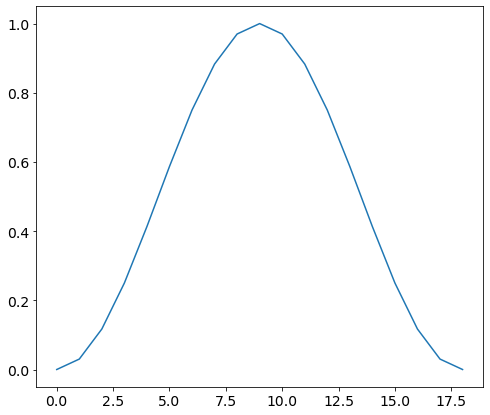

In [7]:
plt.plot(tt)

In [8]:
# whatbhat = whatbhat.set_index(wavenumber= ['freq_lon'])
wavenumber = np.zeros(tcwvhat.freq_lon.size)
for i in range( tcwvhat.freq_lon.size):
    j= - int(360/2) + i
    wavenumber[i]= tcwvhat.freq_lon[int(360/2)+j]*360 + 1
tcwvhat_s['freq_lon'] = wavenumber


# tcwvhat_s = resolveWavesHayashi(tcwvhat, 96, 2)
tcwvhat_s = tcwvhat_s.sel(lat = slice(-15.1,15.1))
# tcwvhat_s = tcwvhat_s.mean('time')

z_symmetric = 2 * tcwvhat_s.isel(lat=tcwvhat_s.lat<0).mean(dim='time').sum(dim='lat').squeeze()
z_symmetric.name = "power"
z_antisymmetric = 2 * tcwvhat_s.isel(lat=tcwvhat_s.lat>0).mean(dim='time').sum(dim='lat').squeeze()
z_antisymmetric.name = "power"



z_final = xr.concat([z_symmetric, z_antisymmetric], "component")
z_final = z_final.assign_coords({"component":["symmetric","antisymmetric"]})
z_final

<xarray.DataArray 'power' (component: 2, freq_lon: 144, freq_segments: 192)>
dask.array<concatenate, shape=(2, 144, 192), dtype=float64, chunksize=(1, 144, 192), chunktype=numpy.ndarray>
Coordinates:
  * freq_segments  (freq_segments) float64 -0.5 -0.4948 ... 0.4896 0.4948
  * freq_lon       (freq_lon) float64 -71.0 -70.0 -69.0 -68.0 ... 70.0 71.0 72.0
  * component      (component) <U13 'symmetric' 'antisymmetric'

In [9]:
z_final = xr.DataArray(np.flip(z_final.values , axis = 1),
                       dims=("component","freq_lon","freq_segments"), 
                       coords={"component" : z_final.component, 
                             "freq_lon":z_final.freq_lon,
                             "freq_segments":z_final.freq_segments})
z_final.name = 'power'

# z_final.loc[{'freq_segments':0}] = np.nan 
z2avg = z_final.mean(dim='component')

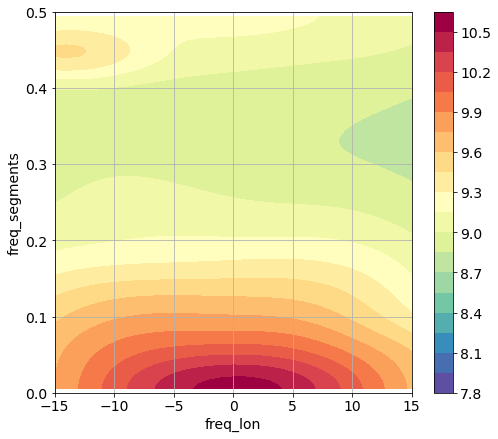

In [10]:
# background = smooth2d(z2avg, 20, cenweight=4.0)
# background = test
background = smooth_wavefreq(z2avg, kern=simple_smooth_kernel(), nsmooth=50, freq_name='freq_segments')


test = background
background.loc[{'freq_segments':0}] = np.nan
_tcwvhat = xu.log10(test) 

_tcwvhat.plot.contourf(x='freq_lon', y = 'freq_segments', ylim = [-0,0.5], xlim =[-15,15], levels = 20,
                       cmap='Spectral_r')
plt.grid()

In [11]:
# separate components
z2_sym = z_final[0]
z2_asy = z_final[1]

# normalize
nspec_sym = z2_sym / background 
nspec_asy = z2_asy / background
nspec_sym['freq_lon'] = wavenumber
nspec_asy['freq_lon'] = wavenumber

nspec_sym['freq_segments'] = spd * nspec_sym['freq_segments']
nspec_asy['freq_segments'] = spd * nspec_asy['freq_segments']
# nspec_sym = np.flip(nspec_sym.values , axis = 0)



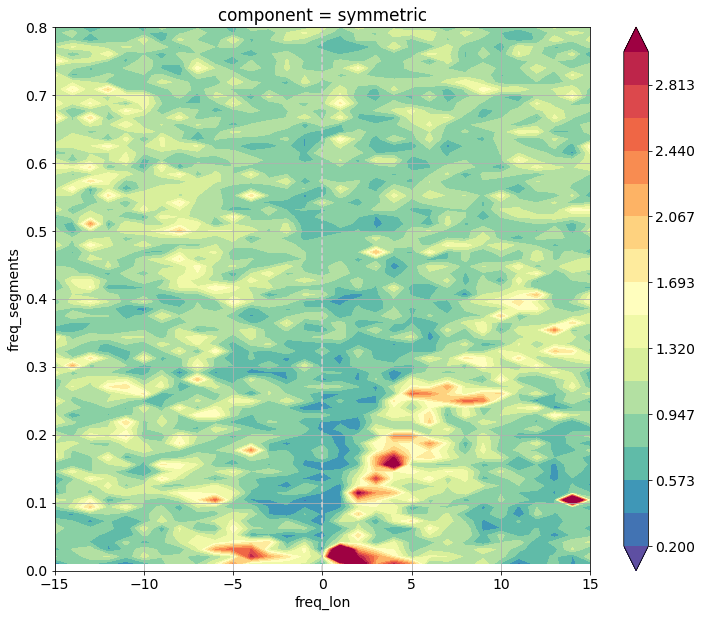

In [12]:
plt.rc("figure", figsize=(12,10))


nspec_sym.plot.contourf(x='freq_lon', y = 'freq_segments', ylim = [-0,0.8], xlim =[-15,15], levels = 16, vmax = 3,
                       cmap='Spectral_r', vmin= 0.2)

ax = plt.gca()
ax.axvline(0, linestyle='dashed', color='lightgray')
plt.grid()


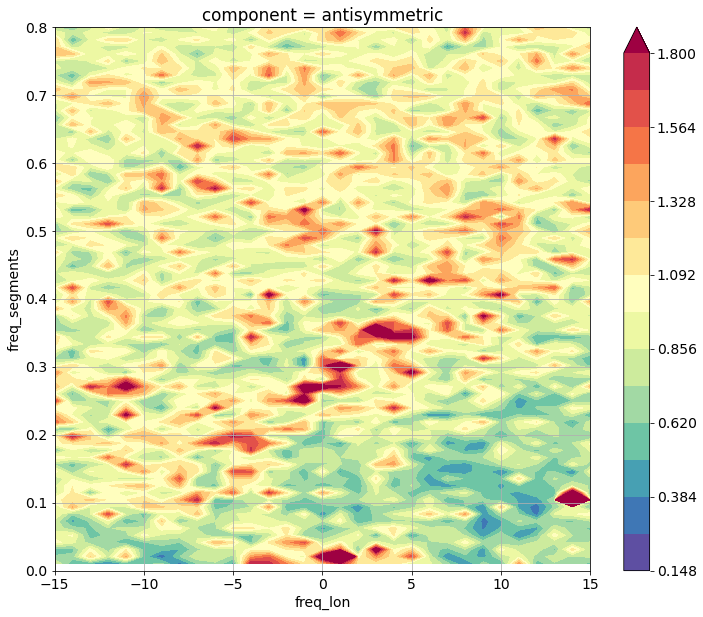

In [13]:
nspec_asy.plot.contourf(x='freq_lon', y = 'freq_segments', levels = 15, xlim =[-15,15], ylim = [-0,0.8], vmax= 1.8,
                       cmap='Spectral_r')
plt.grid()

In [14]:
tcwvhat_s = xrft.power_spectrum(x_wintap, detrend='constant',
            dim=['segments','lon'], true_phase=False, true_amplitude=False,
                               window = 'hann' )

In [15]:
tcwvhat_s = xr.DataArray(np.flip(tcwvhat_s.values , axis = 2),
                       dims=("time", "lat","freq_lon","freq_segments"), 
                       coords={"time" : tcwvhat_s.time,
                               "lat" : tcwvhat_s.lat,
                             "freq_lon":tcwvhat_s.freq_lon,
                             "freq_segments":tcwvhat_s.freq_segments})
z_final.name = 'power'

# z_final.loc[{'freq_segments':0}] = np.nan 
z2avg = z_final.mean(dim='component')

In [16]:
# whatbhat = whatbhat.set_index(wavenumber= ['freq_lon'])
wavenumber = np.zeros(tcwvhat.freq_lon.size)
for i in range( tcwvhat.freq_lon.size):
    j= - int(360/2) + i
    wavenumber[i]= tcwvhat.freq_lon[int(360/2)+j]*360 + 1
tcwvhat_s['freq_lon'] = wavenumber


# tcwvhat_s = resolveWavesHayashi(tcwvhat, 96, 2)
tcwvhat_s = tcwvhat_s.sel(lat = slice(-15.1,15.1))
# tcwvhat_s = tcwvhat_s.mean('time')

z_symmetric = 2 * tcwvhat_s.isel(lat=tcwvhat_s.lat<0).mean(dim='time').sum(dim='lat').squeeze()
z_symmetric.name = "power"
z_antisymmetric = 2 * tcwvhat_s.isel(lat=tcwvhat_s.lat>0).mean(dim='time').sum(dim='lat').squeeze()
z_antisymmetric.name = "power"

z_final = xr.concat([z_symmetric, z_antisymmetric], "component")
z_final = z_final.assign_coords({"component":["symmetric","antisymmetric"]})

In [17]:
whatbhat_2 = tcwvhat_s.mean('time')
whatbhat_2 = whatbhat_2.sel(lat = slice(-15,15))
whatbhat_2 = whatbhat_2.sum(dim = 'lat')

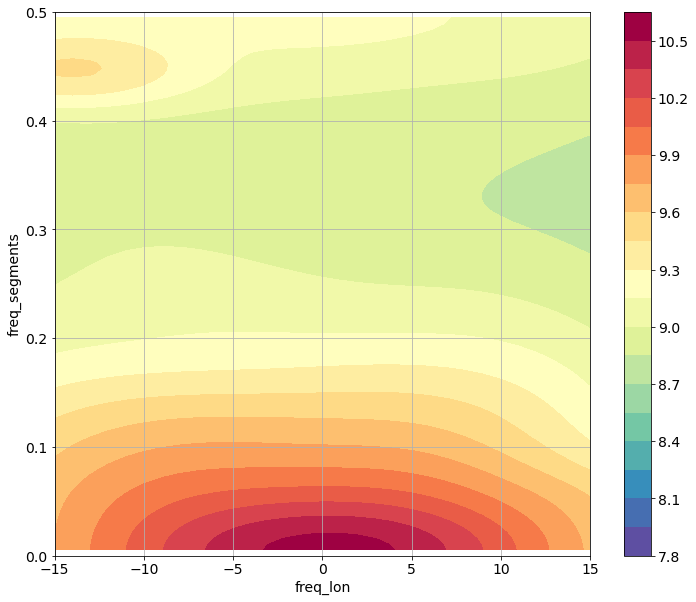

In [18]:
background = smooth_wavefreq(whatbhat_2, kern=simple_smooth_kernel(), nsmooth=50, freq_name='freq_segments')

test = background
background.loc[{'freq_segments':0}] = np.nan

_tcwvhat.plot.contourf(x='freq_lon', y = 'freq_segments', ylim = [-0,0.5], xlim =[-15,15], levels = 20,
                       cmap='Spectral_r')
plt.grid()

In [19]:
# separate components
z2_sym = z_final[0]
z2_asy = z_final[1]

# normalize
nspec_sym = z2_sym / background 
nspec_asy = z2_asy / background
nspec_sym['freq_lon'] = wavenumber
nspec_asy['freq_lon'] = wavenumber

nspec_sym['freq_segments'] = spd * nspec_sym['freq_segments']
nspec_asy['freq_segments'] = spd * nspec_asy['freq_segments']



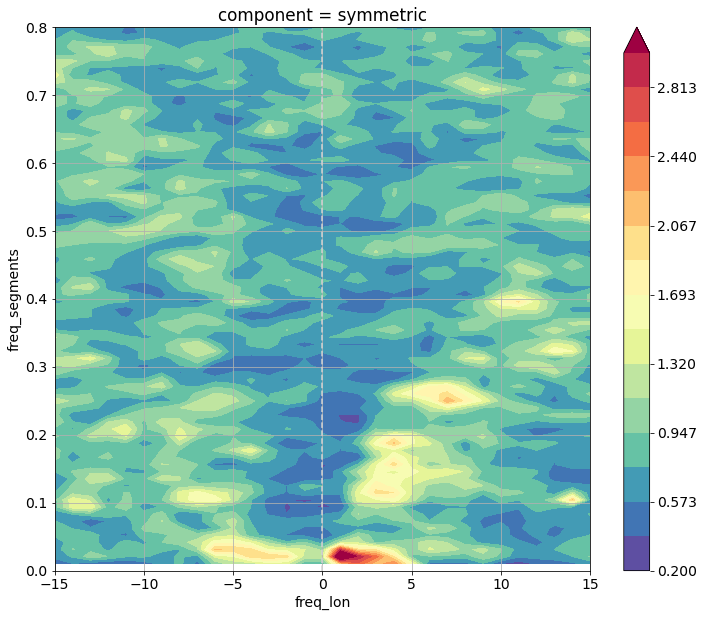

In [20]:
plt.rc("figure", figsize=(12,10))


nspec_sym.plot.contourf(x='freq_lon', y = 'freq_segments', ylim = [-0,0.8], xlim =[-15,15], levels = 16, vmax = 3,
                       cmap='Spectral_r', vmin= 0.2)

ax = plt.gca()
ax.axvline(0, linestyle='dashed', color='lightgray')
plt.grid()


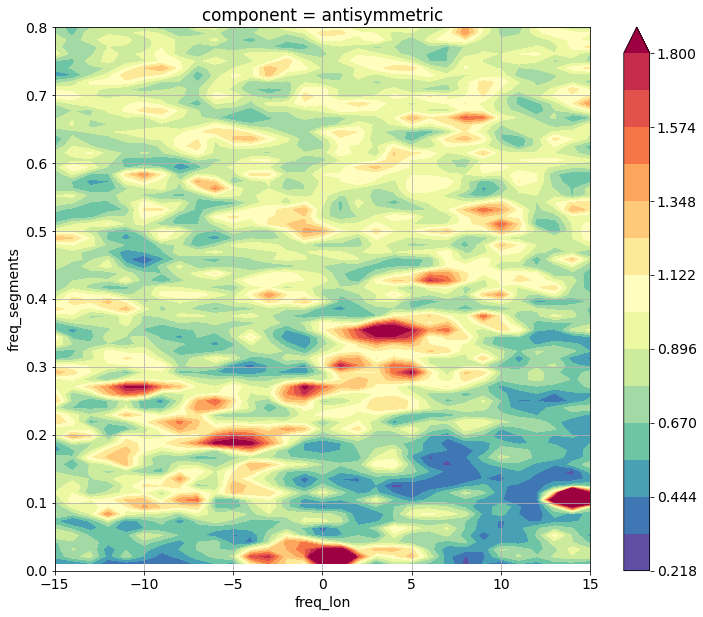

In [21]:
nspec_asy.plot.contourf(x='freq_lon', y = 'freq_segments', levels = 15, xlim =[-15,15], ylim = [-0,0.8], vmax= 1.8,
                       cmap='Spectral_r')
plt.grid()